In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import scipy.stats as sst

%matplotlib inline
pd.options.display.max_rows = 500
pd.options.display.max_columns = 400
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Key functions to calculate policy relatedness, policy alignment and instituional capacity building potential


In [6]:

def calculate_hh_and_weighted_policy_relatedness(M):
    """
    Calculates policy relatedness measures from the M matrix based on 
    two functional forms introduced by Hidalgo et al 2007 and Zaccharia et al 2015 

    Returns
    -------
    Policy relatedness matrices based on these two different functional forms
    """      
    ii = len(M[:,0]) # number of policies
    jj = len(M[0,:]) # number of countries
    
    # Create relatedness matrix for policies
    hh_relatedness_mat = np.zeros((ii,ii))
    weighted_relatedness_mat = np.zeros((ii,ii))
    
    R_i = M.sum(axis = 0)
    
    # For each policy vector in the M matrix, 
    # calculate the relatedness to all other policy vectors
    for this_policy in range(ii):
        this_policy_vec = M[this_policy,:]
        for other_policy in range(ii):
            other_policy_vec = M[other_policy,:]
            overlap = this_policy_vec * other_policy_vec
            pwcp_ij = overlap.sum()/float(this_policy_vec.sum())
            pwcp_ji = overlap.sum()/float(other_policy_vec.sum())            
            
            hh_relatedness_mat[this_policy,other_policy] = np.nan_to_num(min(pwcp_ij,pwcp_ji))
            
    # Now weight the overlap by country policy diversity (1/R_i) - 
    # such that countries that have introduced more policies are assigned lower weight
            overlap_weighted = np.true_divide(overlap,R_i)
            w_pwcp_ij = overlap_weighted.sum()/float(this_policy_vec.sum())
            w_pwcp_ji = overlap_weighted.sum()/float(other_policy_vec.sum())
            
            weighted_relatedness_mat[this_policy,other_policy] = np.nan_to_num(min(w_pwcp_ij,w_pwcp_ji))
                                    
    return hh_relatedness_mat,weighted_relatedness_mat



def calculate_country_policy_alignment(relatedness_mat, M_df,M):
    
    """
    Calculates country policy alignment measures from the policy relatedness matrix and 
    countries' historical mix of policies based on the M matrix

    Returns
    -------
    Country Policy Alignment matrix showing each country's relatedness to each climate policy
    """      
    

    this_countries_list = list(M_df.index)
    this_policies_list = list(M_df.columns)
    country_policy_alignment_matrix = np.zeros((len(this_countries_list),len(this_policies_list)))
    zd_relatedness_matrix = relatedness_mat
    np.fill_diagonal(zd_relatedness_matrix,0)

    for c in range(len(this_countries_list)):
        for p in range(len(this_policies_list)):
            #if the policy exists (which it should)
            if zd_relatedness_matrix[:,p].sum()>0:
                xi = M[c,:]
                relatedness_ij_vect = zd_relatedness_matrix[:,p] #how close is this product to all other products
                numerator = np.dot(xi,relatedness_ij_vect)
                denominator = relatedness_ij_vect.sum()
                country_policy_alignment_matrix[c,p] = np.nan_to_num(numerator/float(denominator))
                
                
    return country_policy_alignment_matrix

def calculate_country_institutional_capacity_building_potential(country, N_df, M_df,M):

    """
    Calculates each policy's institutional capacity building potential for a given country. 
    Only considers policies that a country has no prior experience with. 
    Policies with greater institutional capacity building potential are likely 
    to make it easier for countries to introduce climate policies in the future. 

    Returns
    -------
    Institutional Capacity Building Potential measures for each policy that a given country
    has no prior experience with
    """      
        
    Country_num_policies = N_df.transpose()
    Country_M_df= M_df.transpose()
    Country_policy_alignment_df = weighted_country_policy_alignment_mat_df.transpose()
    Country_policy_alignment_df['policy prevalence']= M.sum(axis = 0)

    Country_policy_relatedness=weighted_relatedness_mat_policy_df.copy()
    # include the specific country's number of policies and RPP for each of the policies
    Country_policy_relatedness["Number_policies_introduced"]=Country_num_policies[country]


    #calculate institutional capacity building potential
    # we want to consider policies that a country has no prior experience with 
    # - and calculate their average relatedness to all other policies 

    no_hist = Country_policy_relatedness[Country_policy_relatedness['Number_policies_introduced']<1]
    no_hist_av_relatedness_to_other_policies = no_hist[list(no_hist.index)]
    no_hist_av_relatedness_to_other_policies['capacity_building_potential']=no_hist_av_relatedness_to_other_policies.mean(axis = 1)

    ICBP = no_hist_av_relatedness_to_other_policies[['capacity_building_potential']]
    return ICBP

### Calculate policy relatedness matrices and associated dataframes


In [8]:

# read in M matrix 
M = np.loadtxt('github_intermediate/M_Nci_matrix.csv', delimiter = ',')
M_df = pd.read_csv('github_intermediate/M_Nci_df.csv',index_col=[0])

#M = np.loadtxt('github_intermediate/M_RPP_matrix.csv', delimiter = ',')
#M_df = pd.read_csv('github_intermediate/M_RPP_df.csv',index_col=[0])

#read in N matrix 
N = np.loadtxt('github_intermediate/N_matrix.csv', delimiter = ',')
N_df = pd.DataFrame(N, index = M_df.index, columns = M_df.columns)

# read in emissions data
emission_df = pd.read_csv('github_intermediate/emission_regression_analysis_df.csv')
emission_df2 = emission_df.set_index('Policy')

# hh policy relatedness measure
hh_relatedness_mat_policy,weighted_relatedness_mat_policy = calculate_hh_and_weighted_policy_relatedness(M.transpose())
weighted_relatedness_mat_policy_df = pd.DataFrame(weighted_relatedness_mat_policy, index = M_df.columns,columns = M_df.columns)

# weighted policy relatedness measure
weighted_country_policy_alignment_mat = calculate_country_policy_alignment(weighted_relatedness_mat_policy,M_df,M)
weighted_country_policy_alignment_mat_df = pd.DataFrame(weighted_country_policy_alignment_mat,index = M_df.index, columns = M_df.columns)

# Calculate a given country's ICBP - in this case, Viet Nam
ICBP = calculate_country_institutional_capacity_building_potential('Viet Nam', N_df, M_df,M)



/var/folders/t0/6smh0nzn0f50n7pt64b0f7xh0000gn/T/ipykernel_86553/2112451553.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_hist_av_relatedness_to_other_policies['capacity_building_potential']=no_hist_av_relatedness_to_other_policies.mean(axis = 1)


### Construct CPFF for given countries

/var/folders/t0/6smh0nzn0f50n7pt64b0f7xh0000gn/T/ipykernel_38034/3744744758.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_hist_av_relatedness_to_other_policies['capacity_building_potential']=no_hist_av_relatedness_to_other_policies.mean(axis = 1)


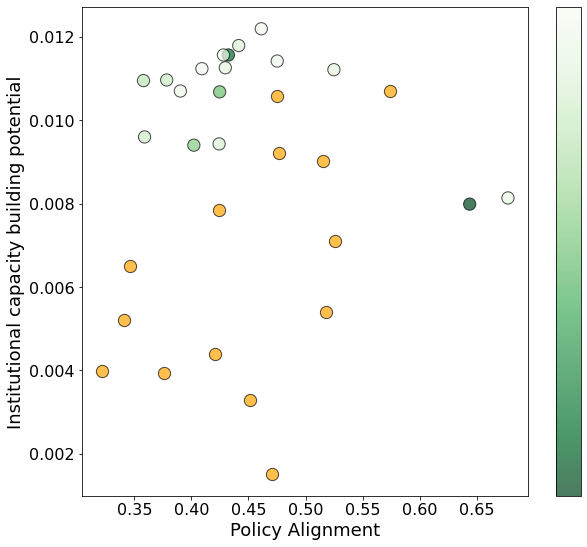

In [79]:
country = 'Viet Nam'

Country_num_policies = N_df.transpose() # Get number of policies country has previously introduced

# Munge requisite dataframes
Country_M_df= M_df.transpose()
Country_policy_alignment_df = weighted_country_policy_alignment_mat_df.transpose()
Country_policy_alignment_df['policy prevalence']= M.sum(axis = 0)

Country_policy_relatedness=weighted_relatedness_mat_policy_df.copy()

# Include the specific country's number of policies and RPP for each of the policies
Country_policy_relatedness["Number_policies_introduced"]=Country_num_policies[country]

# We want to consider policies that a country has no prior experience with 
# - and calculate their average relatedness to all other policies 

no_hist = Country_policy_relatedness[Country_policy_relatedness['Number_policies_introduced']<1]
no_hist_av_relatedness_to_other_policies = no_hist[list(no_hist.index)]
no_hist_av_relatedness_to_other_policies['capacity_building_potential']=no_hist_av_relatedness_to_other_policies.mean(axis = 1)

# Calculate institutional capacity building potential

ICBP = no_hist_av_relatedness_to_other_policies[['capacity_building_potential']]

#output country's institutional capacity building potential for each policy
#ICBP.to_csv('github_outputs/ICBP_'+country+'.csv')

# Include other policy variables we want to show on the CPFF 

CPFF_data_i = ICBP.join(Country_policy_alignment_df[[country,'policy prevalence']])
CPFF_data_i.rename(columns = {country:'policy alignment'}, inplace = True)
CPFF_data = CPFF_data_i.join(emission_df2[['Num_policies_announced', 'Date_of_first_introduction', 'enough_data',
       'statistically_significant', 'emission_reduction_coefficent']])

CPFF_sig = CPFF_data[CPFF_data['statistically_significant']>0]
CPFF_not_sig= CPFF_data[CPFF_data['statistically_significant']<1]

# Plot figure
fig = plt.figure(figsize = (10,9))

plt.scatter(CPFF_not_sig['policy alignment'],CPFF_not_sig['capacity_building_potential'], s = 150, c ='orange', edgecolor = 'black',  alpha = 0.7, marker = 'o')
plt.scatter(CPFF_sig['policy alignment'],CPFF_sig['capacity_building_potential'], s = 150, c = CPFF_sig['emission_reduction_coefficent'],cmap = 'Greens_r', vmin = -0.09,vmax = -0.0, edgecolor = 'black', marker = 'o', alpha = 0.7)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.set_ticks([])

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 3 decimal places

plt.ylabel('Institutional capacity building potential', fontsize = 18)
plt.xlabel('Policy Alignment', fontsize = 18)

plt.savefig('github_outputs/CPFF_'+country+'.pdf',dpi = 200,bbox_inches = 'tight')

